In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from nltk.stem.snowball import RussianStemmer
from collections import Counter
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from sklearn.metrics import f1_score, accuracy_score

In [8]:
pip freeze > requirements

Note: you may need to restart the kernel to use updated packages.


In [2]:
# на всякий случай 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train = pd.read_csv('/kaggle/input/dl-2025-study-competition-2/train.csv')
train_concat = pd.read_csv('/kaggle/input/dl-2025-study-competition-2/train.csv')
test = pd.read_csv('/kaggle/input/dl-2025-study-competition-2/test.csv')

train

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


In [3]:
label_cols = [f'label_{i}' for i in range(20)]
train[label_cols] = train['labels'].apply(lambda x: pd.Series(list(map(int, x.split()))))
train.head()

,id,text,labels,label_0,label_1,label_2,label_3,label_4,label_5,label_6,...,label_10,label_11,label_12,label_13,label_14,label_15,label_16,label_17,label_18,label_19
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,1,0,0,0,1,0,0,...,0,0,1,1,1,1,1,0,0,1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,0,0,0,1,0,0,0,...,0,0,1,1,0,1,1,0,0,1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,0,0,0,0,1,0,0,...,0,0,1,1,0,1,1,0,0,1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,1,1,0,0,1,0,0,...,1,1,1,1,1,0,0,1,1,0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,1,1,0,0,0,0,0,...,0,1,1,1,1,0,1,1,1,0


## EDA

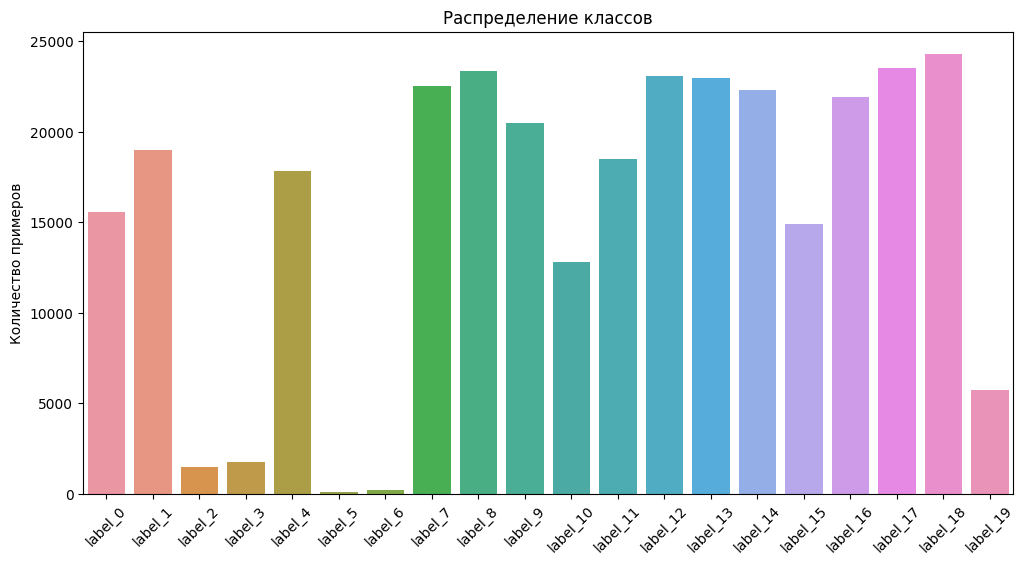

In [4]:
count_class = train[label_cols].sum()

plt.figure(figsize=(12, 6))
sns.barplot(x=count_class.index, y=count_class.values)
plt.title("Распределение классов")
plt.ylabel("Количество примеров")
plt.xticks(rotation=45)
plt.show()

In [5]:
count_class

label_0     15582
label_1     18979
label_2      1490
label_3      1776
label_4     17812
label_5        99
label_6       206
label_7     22555
label_8     23344
label_9     20497
label_10    12811
label_11    18510
label_12    23071
label_13    22997
label_14    22296
label_15    14925
label_16    21933
label_17    23523
label_18    24300
label_19     5765
dtype: int64

Есть классы, в которых очень мало представителей (5, 6 например)

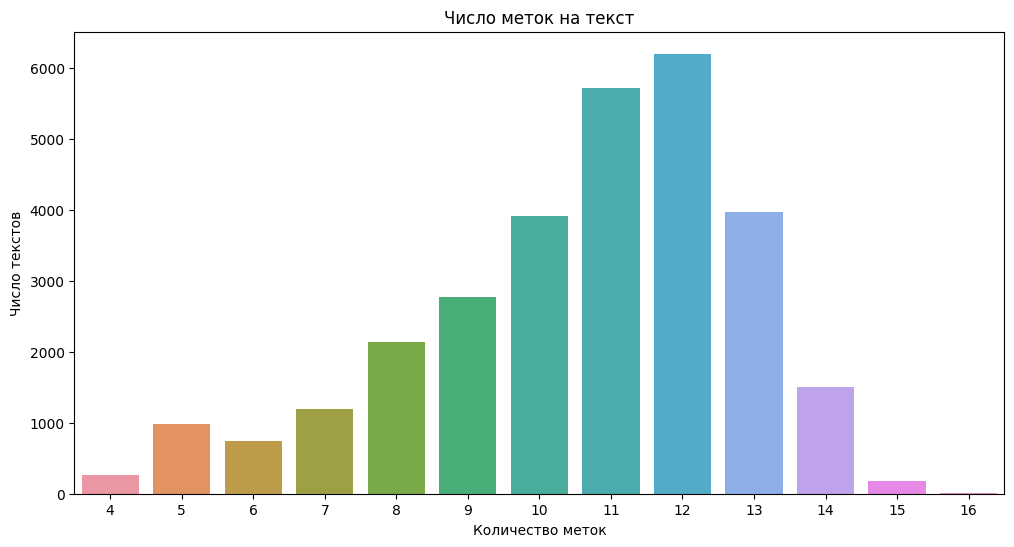

Среднее число меток на текст: 10.567877435064934


In [6]:
train['num_labels'] = train[label_cols].sum(axis=1)

# Сгруппируем количество меток и посчитаем, сколько таких примеров
label_num = train['num_labels'].value_counts().sort_index()

# Построим barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=label_num.index, y=label_num.values)

plt.title("Число меток на текст")
plt.xlabel("Количество меток")
plt.ylabel("Число текстов")
plt.xticks()
plt.yticks()
plt.show()

print("Среднее число меток на текст:", train['num_labels'].mean())

In [7]:
print("Представители класса label_0:\n")
print(train[train['label_0'] == 1]['text'].sample(3, random_state=42).values)

print("\nПредставители класса label_5:\n")
print(train[train['label_5'] == 1]['text'].sample(3, random_state=42).values)


Представители класса label_0:

['Арт-квартал "Хохловка\n"\nТут вы будете рады затеряться в лабиринтах арт-квартала с богатой историей и необычным антуражем, за который его прозвали "местным Берлином". Хохловка — это кофейни, коворкинги и художественные мастерские.\n📍\nХохловский переулок, 7-9'
 'Концерт «Вивальди. Времена года»\n🏛\nЦентральный дом кино\n📍\nул. Васильевская, 13, стр. 1\n🗓\n18 февраля в 17:00\n🗓\n23 февраля в 16:00 и 19:00\n🎫\nБилеты по ссылке здесь\n💚\n-25% по промокоду STAGE\nВсемирно известные произведения Вивальди, Моцарта, Чайковского, Брамса и других великих композиторов в исполнении оркестра Olympic Orchestra прозвучат в темноте концертного зала, где над сценой на огромном экране будут спроецированы живые и красочные картины на воде. Вас ждёт аудиовизуальное наслаждение.\nВ первом отделении музыканты исполнят знаменитый цикл "Времена года" Антонио Вивальди, вторая же часть концерта будет посвящена произведениям Моцарта, Чайковского, Брамса, Массне и Гарделя.\nПрям

In [8]:
print("Представители класса label_19:\n")
print(train[train['label_19'] == 1]['text'].sample(3, random_state=42).values)

print("\nПредставители класса label_3:\n")
print(train[train['label_3'] == 1]['text'].sample(3, random_state=42).values)

Представители класса label_19:

['6 октября\nМК: каллиграфия\n19-00\nhttps://t.me/cma_ufa_rb\nКомарова 14\n📍\nзапись\nhttp://wa.me/79273553637'
 '19 октября\nВечер туристической песни\n19-00 бесплатно\n❗\nhttps://vk.com/wall-30569081_1699\nПервомайская 47'
 '‼️\nПАБАМ\n‼️\nНаш инстаграм готов!\n🎉\nКому интересно, переходите и подписывайтесь\nhttps://www.instagram.com/koncert.ru_bilet/\n. Там мы будем проводить розыгрыши билетов. Выкладывать видео. Всем удачи\n❤️']

Представители класса label_3:

['https://vk.com/wall-8888887_26857'
 'Лучшие шоу при свечах в Петербурге со скидкой 30%\n🔥\n16 июня – «Rock при свечах» на сцене Aurora Concert Hall. Красивая музыка проекта «Звук Света», солисты оперных театров, струнный оркестр, рояль и тысяча свечей на сцене!\n🎻\nБилеты:\nhttps://amadeusconcerts.ru/concerts/rock-pri-svechah/\n17 июня – «Шопен при свечах» в атмосферном зале Яани Кирик. Орган, рояль, флейта и чарующий вокал. Виртуозные музыканты и удивительно красивые сочинения маэстро в мерц

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


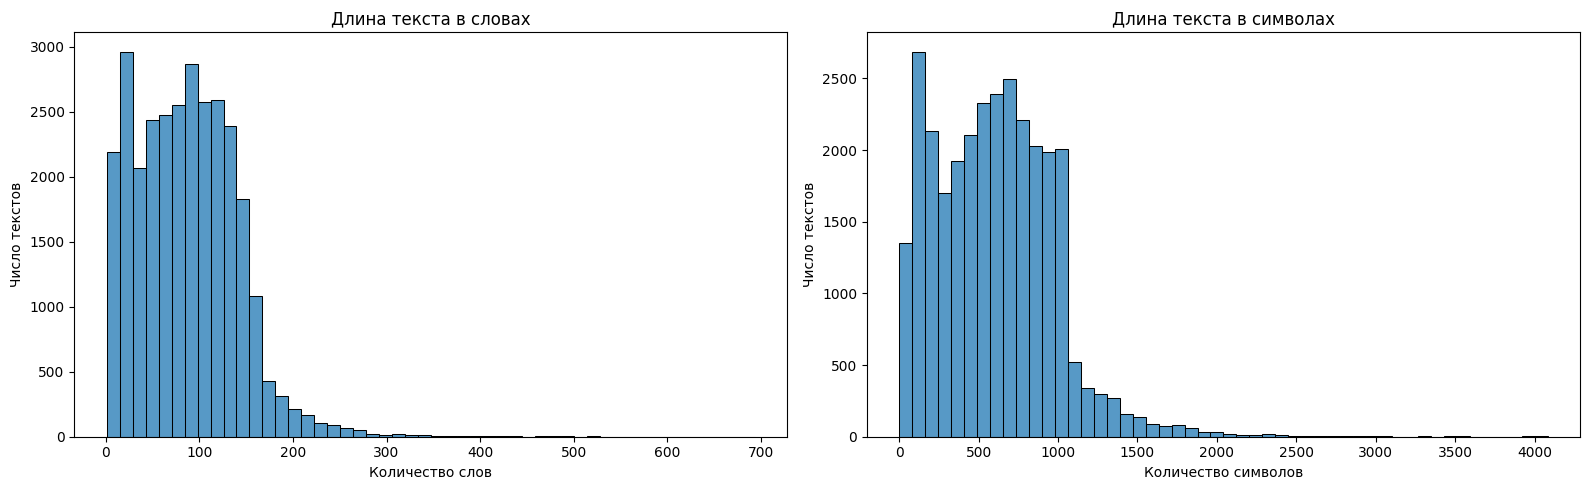

Средняя длина текста (слов): 86.61
Максимальная длина текста (слов): 694
Средняя длина текста (символов): 604.81
Максимальная длина текста (символов): 4081


In [9]:
train['text_len_words'] = train['text'].apply(lambda x: len(str(x).split()))
train['text_len_chars'] = train['text'].apply(lambda x: len(str(x)))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(train['text_len_words'], bins=50, ax=axes[0])
axes[0].set_title("Длина текста в словах")
axes[0].set_xlabel("Количество слов")
axes[0].set_ylabel("Число текстов")

sns.histplot(train['text_len_chars'], bins=50, ax=axes[1])
axes[1].set_title("Длина текста в символах")
axes[1].set_xlabel("Количество символов")
axes[1].set_ylabel("Число текстов")

plt.tight_layout()
plt.show()

print("Средняя длина текста (слов):", round(train['text_len_words'].mean(), 2))
print("Максимальная длина текста (слов):", train['text_len_words'].max())

print("Средняя длина текста (символов):", round(train['text_len_chars'].mean(), 2))
print("Максимальная длина текста (символов):", train['text_len_chars'].max())


In [10]:
short_texts = train[train['text_len_words'] <= 3].sort_values('text_len_words')

print(f"Количество текстов с 3 словами или меньше: {len(short_texts)}")

print("\nПримеры коротких текстов:")
for i, row in short_texts.sample(10).iterrows():
    print(f"{row['text']}")


Количество текстов с 3 словами или меньше: 114

Примеры коротких текстов:
Розы ВДНХ
🥰
https://www.instagram.com/p/CI2ssd5lwVo/?igshid=y06t8lgf6pw8
Розыгрыш!
https://vk.com/wall-8888887_26989
Перенос
❗️
Ребят, берегите себя...
Где насладиться тишиной:
Еврейский музей
Парк «Лога» ночью
Будет вип входной)
Креветочная ароматерапия
🦐


Тут видим очень много ссылок, хочется посмотреть, есть ли примечательные классы у ссылок именно 

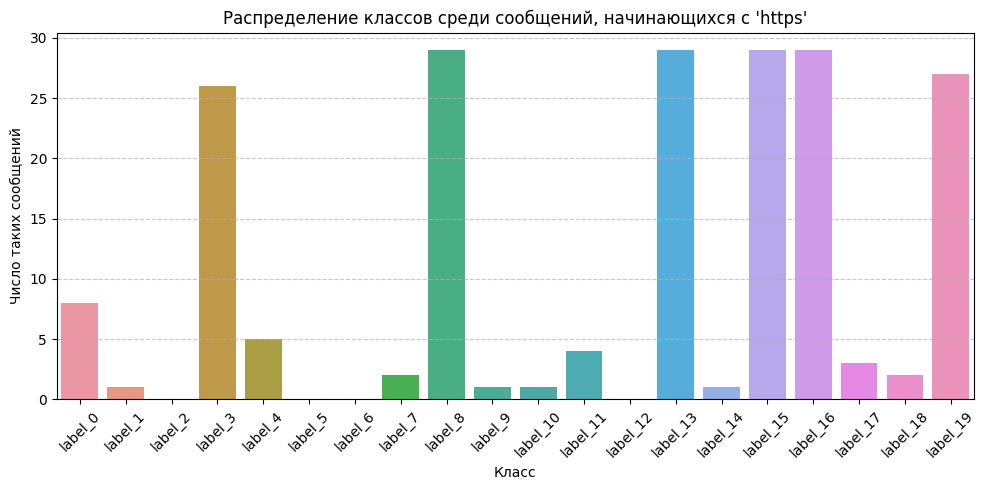

In [11]:
https_texts = train[train['text'].str.strip().str.startswith("https")]

https_label_distribution = https_texts[label_cols].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=https_label_distribution.index, y=https_label_distribution.values)
plt.title("Распределение классов среди сообщений, начинающихся с 'https'")
plt.xlabel("Класс")
plt.ylabel("Число таких сообщений")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Да, действительно, выделяются несколько классов 

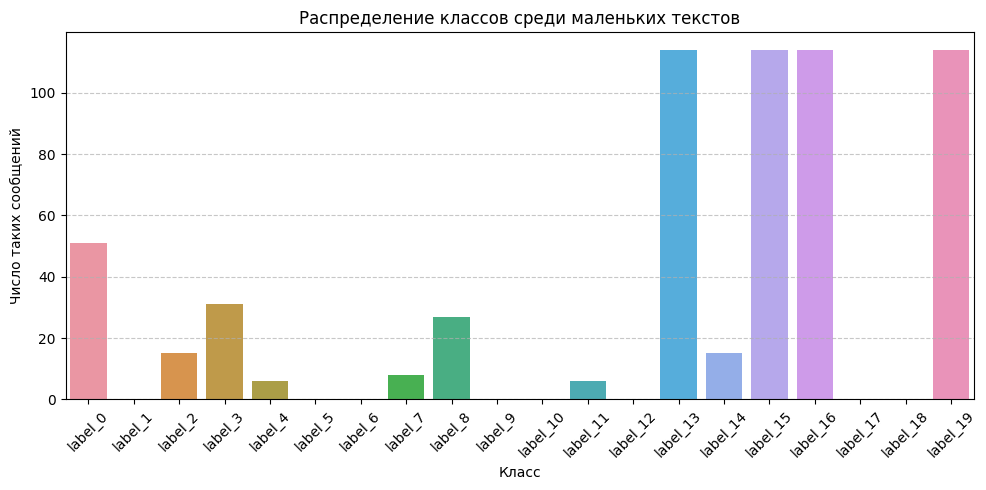

In [12]:
short_label_distribution = short_texts[label_cols].sum()

plt.figure(figsize=(10, 5))
sns.barplot(x=short_label_distribution.index, y=short_label_distribution.values)
plt.title("Распределение классов среди маленьких текстов")
plt.xlabel("Класс")
plt.ylabel("Число таких сообщений")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Препроцессинг

In [4]:
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess_tfidf(text):# нет стоп-слов и латиницы, без эмодзи и url
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " URL ", text)
    text = re.sub(r"[\U00010000-\U0010ffff]", " EMOJI ", text)
    text = re.sub(r'[^а-яё]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [t for t in tokens if t not in russian_stopwords]
    return ' '.join(tokens)

In [6]:
def preprocess_w2v(text): # сохранила стоп-слова и латиницу, без эмодзи и url
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " URL ", text)
    text = re.sub(r"[\U00010000-\U0010ffff]", " EMOJI ", text)
    text = re.sub(r'[^а-яёa-z]', ' ', text)  
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    return ' '.join(tokens) 

In [7]:
def preprocess_conv(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " URL ", text)
    text = re.sub(r"[\U00010000-\U0010ffff]", " EMOJI ", text)
    text = re.sub(r'[^а-яёa-z0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
def preprocess_bertlike(text): # минимум обработки, берт всё может
    return str(text).strip()

In [9]:
train['text_tfidf'] = [preprocess_tfidf(t) for t in tqdm(train['text'], desc="tf-idf")]
train['text_w2v'] = [preprocess_w2v(t) for t in tqdm(train['text'], desc="w2v")]
train['text_conv'] = [preprocess_conv(t) for t in tqdm(train['text'], desc="conv")]
train['text_bert'] = [preprocess_bertlike(t) for t in tqdm(train['text'], desc="bert-like")]


bert-like: 100%|██████████| 29568/29568 [00:00<00:00, 1946497.27it/s]


 ## tf-idf + любая нейронная сеть

In [19]:
label_cols = [f'label_{i}' for i in range(20)]
label_cols

['label_0',
 'label_1',
 'label_2',
 'label_3',
 'label_4',
 'label_5',
 'label_6',
 'label_7',
 'label_8',
 'label_9',
 'label_10',
 'label_11',
 'label_12',
 'label_13',
 'label_14',
 'label_15',
 'label_16',
 'label_17',
 'label_18',
 'label_19']

In [10]:
# Преобразуем текст в векторы
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(train['text_tfidf'])

test_texts = test['text'].astype(str).tolist()
test['text_tfidf'] = [preprocess_tfidf(t) for t in test_texts]
X_test_tfidf = tfidf_vectorizer.transform(test['text_tfidf'])

# Тензоры
X_tensor = torch.tensor(X_tfidf.toarray(), dtype=torch.float32)
y_tensor = torch.tensor(train[label_cols].values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Dataset
class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TestTfidfDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]


In [11]:
test_texts = test['text'].astype(str).tolist()
test['text_tfidf'] = [preprocess_tfidf(t) for t in test_texts]

# Преобразуем в tf-idf
X_test_tfidf = tfidf_vectorizer.transform(test['text_tfidf'])
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2)

train_dataset = TfidfDataset(X_train, y_train)
val_dataset = TfidfDataset(X_val, y_val)
test_dataset = TestTfidfDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [65]:
# модель которая выбирвает скор на каггл

class TfidfClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

def train_model(model, train_loader, val_loader, criterion, optimizer,
                n_epochs=10, scheduler=None, early_stopping_patience=3,
                save_path='best_model.pt', warmup_epochs=2):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    best_f1 = 0
    patience_counter = 0
    train_losses, val_losses = [], []
    val_f1s = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
                all_preds.append(preds)
                all_targets.append(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        preds = np.vstack(all_preds)
        targets = np.vstack(all_targets)
        f1 = f1_score(targets, preds, average='micro')
        val_f1s.append(f1)

        if scheduler:
            if epoch < warmup_epochs:
                for param_group in optimizer.param_groups:
                    param_group["lr"] *= 1.2  # Простая warmup стратегия
            else:
                scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, F1: {f1:.4f}")

        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print("New best model saved")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping")
                break

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss over epochs")

    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label="Val F1")
    plt.legend()
    plt.title("F1 Score over epochs")
    plt.show()


Epoch 1: Train Loss: 0.6859, Val Loss: 0.6784, F1: 0.7221
New best model saved
Epoch 2: Train Loss: 0.6417, Val Loss: 0.5829, F1: 0.7895
New best model saved
Epoch 3: Train Loss: 0.5167, Val Loss: 0.4804, F1: 0.7964
New best model saved
Epoch 4: Train Loss: 0.4680, Val Loss: 0.4601, F1: 0.8008
New best model saved
Epoch 5: Train Loss: 0.4512, Val Loss: 0.4438, F1: 0.8073
New best model saved
Epoch 6: Train Loss: 0.4299, Val Loss: 0.4181, F1: 0.8241
New best model saved
Epoch 7: Train Loss: 0.4005, Val Loss: 0.3876, F1: 0.8447
New best model saved
Epoch 8: Train Loss: 0.3726, Val Loss: 0.3649, F1: 0.8508
New best model saved
Epoch 9: Train Loss: 0.3535, Val Loss: 0.3511, F1: 0.8529
New best model saved
Epoch 10: Train Loss: 0.3414, Val Loss: 0.3421, F1: 0.8555
New best model saved
Epoch 11: Train Loss: 0.3328, Val Loss: 0.3352, F1: 0.8589
New best model saved
Epoch 12: Train Loss: 0.3256, Val Loss: 0.3296, F1: 0.8613
New best model saved
Epoch 13: Train Loss: 0.3196, Val Loss: 0.3244, F

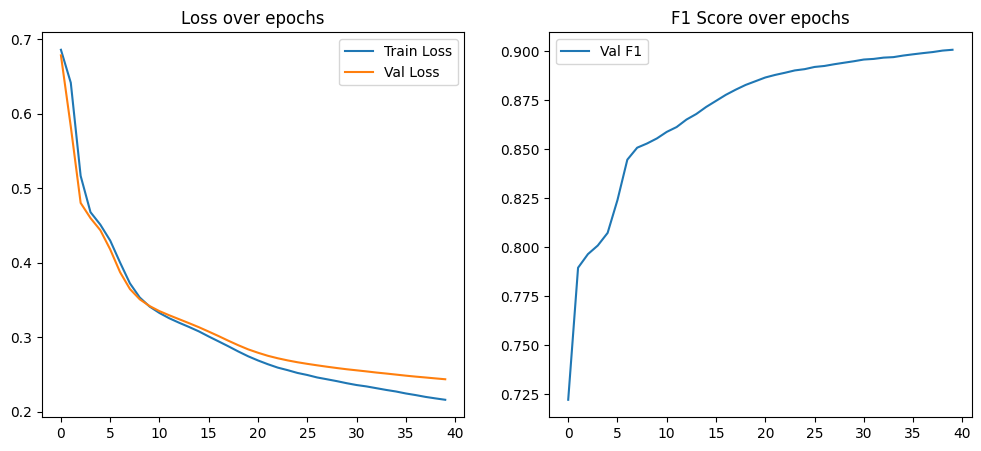

In [67]:
input_dim = X_tensor.shape[1]
output_dim = y_tensor.shape[1]

model = TfidfClassifier(input_dim, output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    n_epochs=40,
    scheduler=scheduler,
    early_stopping_patience=5,
    save_path='tfidf_best_model.pt',
    warmup_epochs=5
)


In [25]:
model.load_state_dict(torch.load('tfidf_best_model.pt'))
model.eval()

/tmp/ipykernel_176/3075685917.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('tfidf_best_model.pt'))


TfidfClassifier(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=20, bias=True)
  )
)

In [26]:

def predict(model, dataloader):
    model.eval()
    all_preds = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        for X_batch in dataloader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)

    return np.vstack(all_preds)

# Прогнозы на тестовом датасете
test_preds = predict(model, test_loader)

# Преобразуем в бинарные метки
preds_binary = (test_preds > 0.5).astype(int)

In [27]:
def create_labels(preds):
    return ' '.join(map(str, preds))

label_strings = [create_labels(pred) for pred in preds_binary]

submission_df = pd.DataFrame({'id': test['id'], 'labels': label_strings})

# Сохраняем в CSV
submission_df.to_csv('kaggle_submission.csv', index=False)

In [28]:
submission_df

,id,labels
0,29568,0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0
1,29569,0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1
2,29570,0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3,29571,1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0
4,29572,1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0
...,...,...
7387,36955,0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
7388,36956,1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
7389,36957,0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0
7390,36958,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0


Выбила 0.83994 на сабмите

 ## w2v + любая нейронная сеть

Попробую ту же нейронку + вордтувек

In [29]:
from gensim.models import Word2Vec

# Обучим Word2Vec на токенизированных текстах
w2v_model = Word2Vec(
    sentences=train['text_w2v'],
    vector_size=300,  # размер эмбеддинга
    window=5,
    min_count=2,
    workers=4,
    sg=1  # skip-gram
)

# Сохраним словарь
w2v_vocab = set(w2v_model.wv.index_to_key)

In [30]:
test['text_w2v'] = [preprocess_w2v(t) for t in tqdm(test['text'], desc="w2v")]

w2v: 100%|██████████| 7392/7392 [00:00<00:00, 9843.57it/s]


In [31]:
def get_text_embedding(tokens, model, vector_size=300):
    valid_tokens = [t for t in tokens if t in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    vectors = [model.wv[t] for t in valid_tokens]
    return np.mean(vectors, axis=0)

# Получим векторные представления для каждого текста
X_w2v = np.array([get_text_embedding(tokens, w2v_model, 300) for tokens in train['text_w2v']])
X_test_w2v = np.array([get_text_embedding(tokens, w2v_model, 300) for tokens in test['text_w2v']])


In [32]:
X_train_w2v, X_val_w2v, y_train_w2v, y_val_w2v = train_test_split(
    X_w2v,
    train[label_cols].values,
    test_size=0.2,
    random_state=42
)

# В тензоры
X_train_tensor = torch.tensor(X_train_w2v, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_w2v, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_w2v, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_w2v, dtype=torch.float32)

In [33]:
X_tensor_w2v = torch.tensor(X_w2v, dtype=torch.float32)
y_tensor_w2v = torch.tensor(train[label_cols].values, dtype=torch.float32)
X_test_tensor_w2v = torch.tensor(X_test_w2v, dtype=torch.float32)

class W2VDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TestW2VDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

train_dataset_w2v = W2VDataset(X_train_tensor, y_train_tensor)
val_dataset_w2v = W2VDataset(X_val_tensor, y_val_tensor)
test_dataset_w2v = TestW2VDataset(X_test_tensor_w2v)

train_loader_w2v = DataLoader(train_dataset_w2v, batch_size=64, shuffle=True)
val_loader_w2v = DataLoader(val_dataset_w2v, batch_size=64, shuffle=False)
test_loader_w2v = DataLoader(test_dataset_w2v, batch_size=64, shuffle=False)

Epoch 1: Train Loss: 0.5383, Val Loss: 0.4888, F1: 0.7946
New best model saved
Epoch 2: Train Loss: 0.4836, Val Loss: 0.4747, F1: 0.7980
New best model saved
Epoch 3: Train Loss: 0.4730, Val Loss: 0.4646, F1: 0.8057
New best model saved
Epoch 4: Train Loss: 0.4600, Val Loss: 0.4457, F1: 0.8101
New best model saved
Epoch 5: Train Loss: 0.4383, Val Loss: 0.4195, F1: 0.8251
New best model saved
Epoch 6: Train Loss: 0.4207, Val Loss: 0.4046, F1: 0.8296
New best model saved
Epoch 7: Train Loss: 0.4099, Val Loss: 0.3960, F1: 0.8332
New best model saved
Epoch 8: Train Loss: 0.4024, Val Loss: 0.3905, F1: 0.8357
New best model saved
Epoch 9: Train Loss: 0.3981, Val Loss: 0.3872, F1: 0.8340
Epoch 10: Train Loss: 0.3950, Val Loss: 0.3839, F1: 0.8365
New best model saved
Epoch 11: Train Loss: 0.3915, Val Loss: 0.3829, F1: 0.8333
Epoch 12: Train Loss: 0.3895, Val Loss: 0.3792, F1: 0.8383
New best model saved
Epoch 13: Train Loss: 0.3874, Val Loss: 0.3771, F1: 0.8386
New best model saved
Epoch 14: T

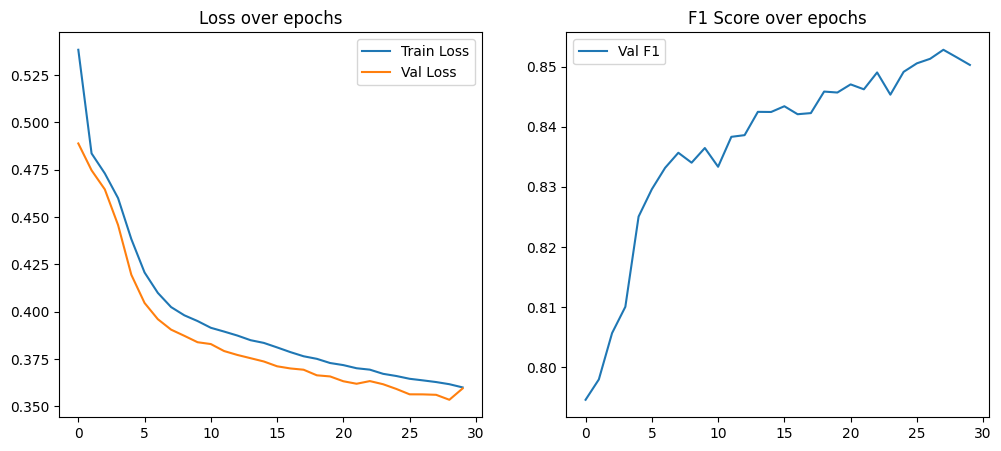

In [34]:
input_dim = X_tensor_w2v.shape[1]
output_dim = y_tensor_w2v.shape[1]

model = TfidfClassifier(input_dim, output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_model(
    model, train_loader_w2v, val_loader_w2v,
    criterion, optimizer,
    n_epochs=30,
    scheduler=scheduler,
    early_stopping_patience=4,
    save_path='tfidf_best_model.pt',
    warmup_epochs=4
)

Будто неоч

In [35]:

model.load_state_dict(torch.load('tfidf_best_model.pt'))
model.eval()
def predict_w2v(model, dataloader):
    model.eval()
    all_preds = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)

    return np.vstack(all_preds)


# Прогнозы на тестовом датасете
test_preds = predict_w2v(model, test_loader_w2v)

# Преобразуем в бинарные метки
preds_binary = (test_preds > 0.5).astype(int)

/tmp/ipykernel_176/2502660770.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('tfidf_best_model.pt'))


In [36]:
def create_labels(preds):
    return ' '.join(map(str, preds))

label_strings = [create_labels(pred) for pred in preds_binary]

submission_df = pd.DataFrame({'id': test['id'], 'labels': label_strings})

# Сохраняем в CSV
submission_df.to_csv('kaggle_submission_w2v.csv', index=False)

## встроенный эмбеддинг в нейросетевое решение на свёрточных сетях

In [13]:
class TestDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

test['text_conv'] = [preprocess_conv(t) for t in tqdm(test['text'], desc="conv_test")]

def tokenize(text):
    return text.split()

# Токенизация текста
tokenized_texts = [tokenize(t) for t in train['text_conv']]
tokenized_test = [tokenize(t) for t in test['text_conv']]

all_tokens = [token for tokens in tokenized_texts for token in tokens]
token_counts = Counter(all_tokens)
vocab = {word: idx + 1 for idx, (word, _) in enumerate(token_counts.most_common())}  # индексы начинаются с 1
vocab_size = len(vocab) + 1  # +1 для паддинга

def text_to_indices(tokens, vocab):
    return [vocab.get(token, 0) for token in tokens]


indexed_texts = [text_to_indices(tokens, vocab) for tokens in tokenized_texts]
indexed_test = [text_to_indices(tokens, vocab) for tokens in tokenized_test]

X_train_padded = pad_sequence([torch.tensor(text) for text in indexed_texts], batch_first=True, padding_value=0)
X_test_padding = pad_sequence([torch.tensor(text) for text in indexed_test], batch_first=True, padding_value=0)


y_train = torch.tensor(train[label_cols].values, dtype=torch.long)
y_test = torch.tensor(train[label_cols].values, dtype=torch.long)

X_train, X_val, y_train, y_val = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)


# Создаём DataLoader
train_dataset = TextDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TextDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TestDataset(X_test_padding)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

conv_test: 100%|██████████| 7392/7392 [00:00<00:00, 11359.73it/s]
/tmp/ipykernel_31/514804889.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.long)
/tmp/ipykernel_31/514804889.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.long)
/tmp/ipykernel_31/514804889.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_31/514804889.py:55: UserWarning: To copy construct from a tensor, it is

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                n_epochs=10, scheduler=None, early_stopping_patience=3,
                save_path='best_model.pt', warmup_epochs=1):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    best_f1 = 0
    patience_counter = 0
    train_losses, val_losses = [], []
    val_f1s = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
           
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
                all_preds.append(preds)
                all_targets.append(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        preds = np.vstack(all_preds)
        targets = np.vstack(all_targets)
        f1 = f1_score(targets, preds, average='micro')
        val_f1s.append(f1)

        if scheduler:
            if epoch < warmup_epochs:
                for param_group in optimizer.param_groups:
                    param_group["lr"] *= 1.2  # Простая warmup стратегия
            else:
                scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, F1: {f1:.4f}")

        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print("New best model saved")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping")
                break

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss over epochs")

    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label="Val F1")
    plt.legend()
    plt.title("F1 Score over epochs")
    plt.show()


In [39]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes=20): 
        super(CNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes) 

    def forward(self, x):
        x = self.embedding(x) 
        x = x.permute(0, 2, 1) 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x) 


Epoch 1: Train Loss: 0.5445, Val Loss: 0.4653, F1: 0.8015
New best model saved
Epoch 2: Train Loss: 0.4619, Val Loss: 0.4302, F1: 0.8235
New best model saved
Epoch 3: Train Loss: 0.4272, Val Loss: 0.3964, F1: 0.8390
New best model saved
Epoch 4: Train Loss: 0.3970, Val Loss: 0.3673, F1: 0.8542
New best model saved


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5: Train Loss: 0.3731, Val Loss: 0.3447, F1: 0.8625
New best model saved


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 6: Train Loss: 0.3575, Val Loss: 0.3357, F1: 0.8665
New best model saved


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 7: Train Loss: 0.3484, Val Loss: 0.3279, F1: 0.8697
New best model saved


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 8: Train Loss: 0.3404, Val Loss: 0.3205, F1: 0.8732
New best model saved


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 9: Train Loss: 0.3336, Val Loss: 0.3142, F1: 0.8756
New best model saved


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 10: Train Loss: 0.3276, Val Loss: 0.3085, F1: 0.8776
New best model saved


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 11: Train Loss: 0.3213, Val Loss: 0.3033, F1: 0.8793
New best model saved


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 12: Train Loss: 0.3158, Val Loss: 0.2991, F1: 0.8807
New best model saved


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 13: Train Loss: 0.3108, Val Loss: 0.2940, F1: 0.8829
New best model saved


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 14: Train Loss: 0.3065, Val Loss: 0.2903, F1: 0.8844
New best model saved


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 15: Train Loss: 0.3021, Val Loss: 0.2870, F1: 0.8853
New best model saved


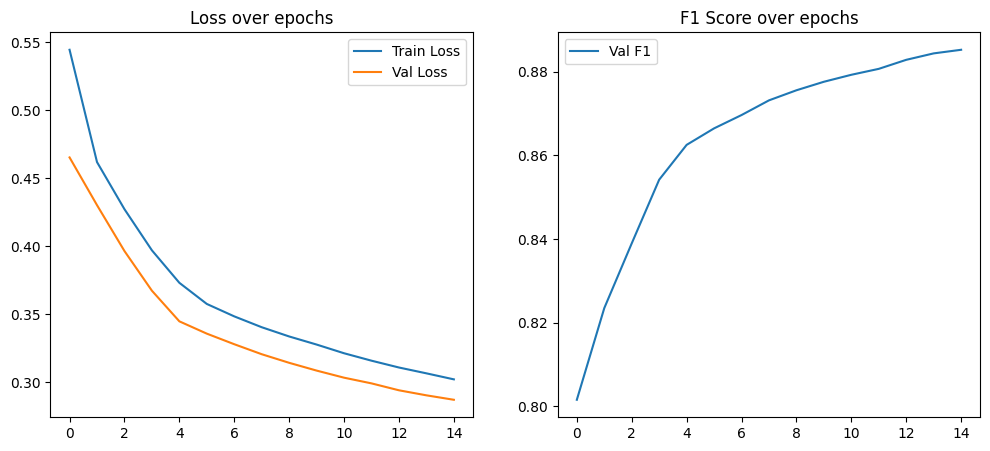

In [40]:
# Задаём параметры
model = CNNClassifier(vocab_size, embed_dim=100, num_classes=20)

# Оптимизатор, loss и scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()  # Для мульти-лейбл классификации
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=15)

# Тренировка модели
train_model(model, train_loader, val_loader, criterion, optimizer, 
            n_epochs=15, scheduler=scheduler, early_stopping_patience=3, 
            save_path='best_cnn_model.pt', warmup_epochs=4)


## встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях

In [15]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=20):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 из-за bidirectional

    def forward(self, x):
        x = self.embedding(x)  
        _, h_n = self.gru(x)  
        h_n = torch.cat((h_n[0], h_n[1]), dim=1) 
        x = self.dropout(h_n)
        return self.fc(x)  

In [16]:
def train_model_rnn(model, train_loader, val_loader, criterion, optimizer,
                n_epochs=10, scheduler=None, early_stopping_patience=3,
                save_path='best_model.pt', warmup_epochs=1):
    
    device = torch.device('cpu')  # Для диагностики
    model.to(device)
    best_f1 = 0
    patience_counter = 0
    train_losses, val_losses = [], []
    val_f1s = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
           
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
                all_preds.append(preds)
                all_targets.append(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        preds = np.vstack(all_preds)
        targets = np.vstack(all_targets)
        f1 = f1_score(targets, preds, average='micro')
        val_f1s.append(f1)

        if scheduler:
            if epoch < warmup_epochs:
                for param_group in optimizer.param_groups:
                    param_group["lr"] *= 1.2  # Простая warmup стратегия
            else:
                scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, F1: {f1:.4f}")

        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print("New best model saved")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping")
                break

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss over epochs")

    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label="Val F1")
    plt.legend()
    plt.title("F1 Score over epochs")
    plt.show()


Epoch 1: Train Loss: 0.6305, Val Loss: 0.5048, F1: 0.7967
New best model saved
Epoch 2: Train Loss: 0.4946, Val Loss: 0.4831, F1: 0.7991
New best model saved
Epoch 3: Train Loss: 0.4626, Val Loss: 0.4125, F1: 0.8289
New best model saved
Epoch 4: Train Loss: 0.3941, Val Loss: 0.3727, F1: 0.8441
New best model saved
Epoch 5: Train Loss: 0.3617, Val Loss: 0.3460, F1: 0.8522
New best model saved
Epoch 6: Train Loss: 0.3445, Val Loss: 0.3377, F1: 0.8571
New best model saved
Epoch 7: Train Loss: 0.3363, Val Loss: 0.3314, F1: 0.8604
New best model saved
Epoch 8: Train Loss: 0.3307, Val Loss: 0.3261, F1: 0.8637
New best model saved
Epoch 9: Train Loss: 0.3254, Val Loss: 0.3220, F1: 0.8665
New best model saved
Epoch 10: Train Loss: 0.3217, Val Loss: 0.3187, F1: 0.8674
New best model saved
Epoch 11: Train Loss: 0.3185, Val Loss: 0.3159, F1: 0.8682
New best model saved
Epoch 12: Train Loss: 0.3156, Val Loss: 0.3137, F1: 0.8702
New best model saved
Epoch 13: Train Loss: 0.3133, Val Loss: 0.3115, F

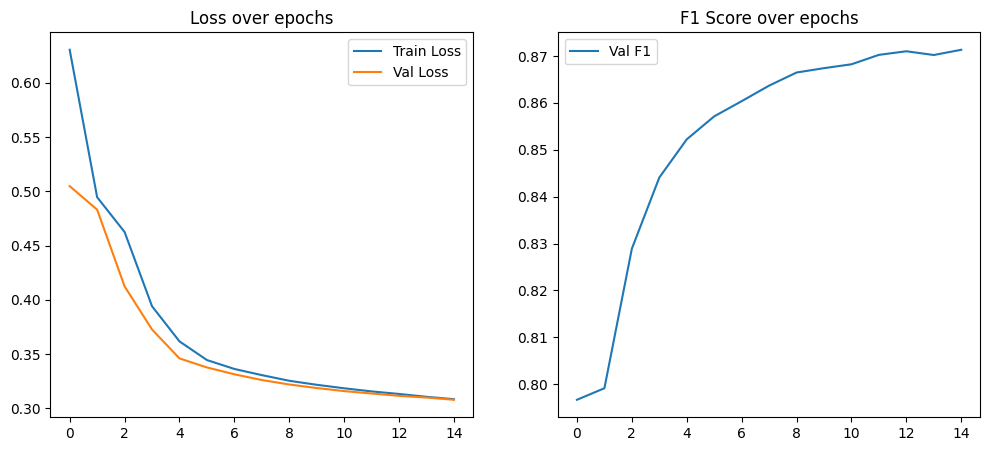

In [19]:
# Задаём параметры
model = RNNClassifier(vocab_size, embed_dim=100, hidden_dim=100, num_classes=20)

# Оптимизатор, loss и scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()  # Для мульти-лейбл классификации
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=15)

# Тренировка модели
train_model(model, 
            train_loader, 
            val_loader, 
            criterion, optimizer, 
            n_epochs=15, scheduler=scheduler, 
            early_stopping_patience=3, 
            save_path='best_cnn_model.pt', warmup_epochs=4)


### эмбеддер + решение на bert-like моделях (любой вид)

In [2]:
pip install transformers datasets evaluate scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer,DistilBertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import f1_score, accuracy_score

In [28]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [29]:
# токенизация
inputs = tokenizer(list(train['text_bert']), padding=True, truncation=True, return_tensors="pt", max_length=512)

In [21]:
y = train[label_cols].values

labels = torch.tensor(train[label_cols].values, dtype=torch.float32)

dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 370/370 [01:50<00:00,  3.34it/s]


Epoch 1: Train Loss=0.2892, Val Loss=0.2323, F1=0.7653, Acc=0.1255


Validation: 100%|██████████| 370/370 [01:51<00:00,  3.33it/s]


Epoch 2: Train Loss=0.2187, Val Loss=0.2068, F1=0.7744, Acc=0.1726


Validation: 100%|██████████| 370/370 [01:51<00:00,  3.33it/s]


Epoch 3: Train Loss=0.1944, Val Loss=0.1909, F1=0.7786, Acc=0.2103


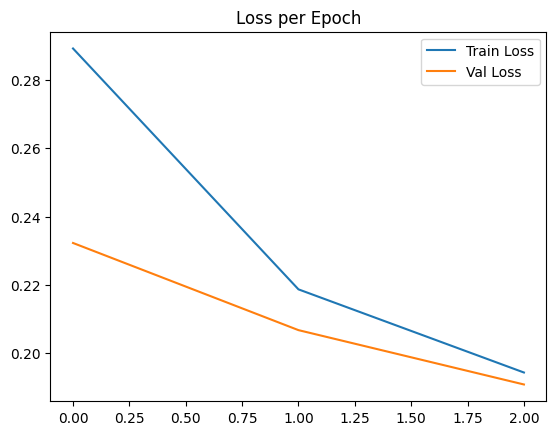

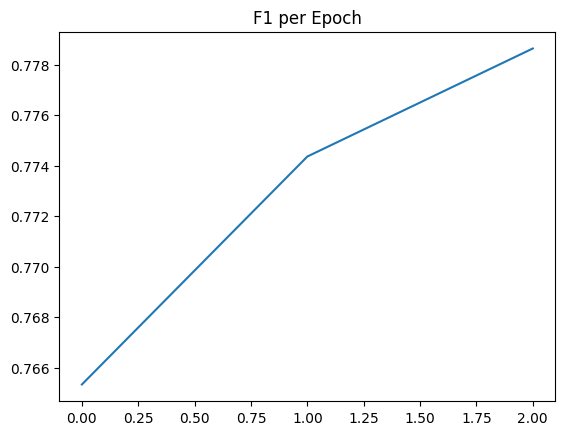

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_labels = 20

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=num_labels).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
patience = 3
counter = 0

for epoch in range(3):
    # ---- Training ----
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    avg_val_loss = total_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    acc = accuracy_score(all_labels, all_preds)

    val_losses.append(avg_val_loss)
    val_f1s.append(f1)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, F1={f1:.4f}, Acc={acc:.4f}")

    # Early stopping
    if f1 > best_f1:
        best_f1 = f1
        counter = 0
        torch.save(model.state_dict(), "best_bert_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

# --- Визуализация ---
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss per Epoch")
plt.show()

plt.plot(val_f1s, label="Val F1")
plt.title("F1 per Epoch")
plt.show()


Тут не судите строго, не могу позволить себе много эпох с вычислительной точки зрения (уходит очень много времени на берты) Метрика F1 не очень, поэтому не буду коммититься с этой модельки

In [1]:
model.eval()

def predict_bert_multilabel(model, dataloader, device, threshold=0.5):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            input_ids, attention_mask, _ = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits)
            all_probs.append(probs.cpu().numpy())

    probs_all = np.vstack(all_probs)
    preds_binary = (probs_all > threshold).astype(int)
    return preds_binary

NameError: name 'model' is not defined

In [ ]:
preds_binary = predict_bert_multilabel(model, test_loader, device)

In [ ]:
def create_labels(preds):
    return ' '.join(map(str, preds))

label_strings = [create_labels(pred) for pred in preds_binary]

submission_df = pd.DataFrame({'id': test['id'], 'labels': label_strings})

In [ ]:
submission_df.to_csv("bert_submission.csv", index=False)

## Генерация текста для поставки в модель 

In [5]:
class_descriptions = ["Анонсы мероприятий и выступлений",
    "Анонсы мероприятий в сфере искусств",
    "Анонсы с описанием музыкальных мероприятий",
    "Пост с призывом прийти на мероприятие",
    "Пост упоминающий стоимость билетов на мероприятие",
    "Анонс мероприятия для женщин или детей",
    "Пост призыв прийти на художественное мероприятие",
    "Пост призыв прийти на музыкальное мероприятие",
    "Анонс мероприятия с адресом",
    "Анонс мероприятия с билетами по скидке",
    "Длинное и эмоциональное описание культурного мероприятия с призывом пойти на него",
    "Призыв на культурное меропритие с рассказом об истории из жизни",
    "Анонс веселого и поднимающего настроение мероприятия",
    "Анонс концерта",
    "Анонс выступления с упоминанием имени и фамилии выступающего",
    "Приглашение на культурное мероприятие",
    "Анонс меропрития театра и кино",
    "Анонс культурного меропрития, на котором можно узнать новое",
    "Анонс культурного меропрития в игровом формате",
    "Анонс меропрития, приуроченного с особому событию"
]

In [6]:
train['labels'] = train['labels'].apply(lambda x: list(map(int, x.split())))

label_matrix = np.array(train['labels'].tolist())

label_sums = label_matrix.sum(axis=0)
print(label_sums)

[15582 18979  1490  1776 17812    99   206 22555 23344 20497 12811 18510
 23071 22997 22296 14925 21933 23523 24300  5765]


In [7]:
def generate_labels_with_distribution(label_sums, num_samples=1000):
    label_probabilities = label_sums / label_sums.sum()
    num_classes = len(label_probabilities)
    
    labels = []
    for _ in range(num_samples):
        while True:
            sample = (np.random.rand(num_classes) < label_probabilities).astype(int)
            if sample.sum() > 0:
                labels.append(sample)
                break

    return np.array(labels)


new_label_matrix = generate_labels_with_distribution(label_sums, num_samples=1000)
new_labels = [' '.join(map(str, row)) for row in new_label_matrix]


In [8]:
def create_prompt(label_string, class_descriptions):
    label_vector = list(map(int, label_string.strip().split()))
    # Берём только те описания, где метка == 1
    labels = [class_descriptions[i] for i, val in enumerate(label_vector) if val == 1]

    theme = ', '.join(labels)
    prompt = f"Напишите короткую статью на темы: {theme}. Текст должен быть информативным и интересным."
    return prompt

prompts = [create_prompt(row, class_descriptions) for row in new_labels]

In [9]:
prompts[:5]

['Напишите короткую статью на темы: Анонс выступления с упоминанием имени и фамилии выступающего. Текст должен быть информативным и интересным.',
 'Напишите короткую статью на темы: Пост призыв прийти на музыкальное мероприятие. Текст должен быть информативным и интересным.',
 'Напишите короткую статью на темы: Приглашение на культурное мероприятие. Текст должен быть информативным и интересным.',
 'Напишите короткую статью на темы: Приглашение на культурное мероприятие, Анонс меропрития театра и кино. Текст должен быть информативным и интересным.',
 'Напишите короткую статью на темы: Пост упоминающий стоимость билетов на мероприятие. Текст должен быть информативным и интересным.']

In [10]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "ai-forever/rugpt3large_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

def generate_text_from_prompt(prompt, max_length=200):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
    output = model.generate(
        input_ids,
        max_length=max_length,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=1.0,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(output[0], skip_special_tokens=True)


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

In [11]:
generated_texts = []
for prompt in tqdm(prompts, desc="Генерация текстов"):
    text = generate_text_from_prompt(prompt)
    generated_texts.append(text)

Генерация текстов: 100%|██████████| 1000/1000 [50:50<00:00,  3.05s/it]


In [16]:
def strip_prompt(generated_text, prompt): # убираю промпт из генерации
    return generated_text[len(prompt):].strip()

cleaned_texts = [strip_prompt(text, prompt) for text, prompt in zip(generated_texts, prompts)]

In [20]:
df = pd.DataFrame({
    "text": cleaned_texts,
    "labels": new_labels
})
df

,text,labels
0,Билеты на концерт «Манифеста» в театре Олимп в...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
1,Подойдет и для статей на другие темы: о детях ...,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
2,"В тексте может быть несколько фото и видео, чт...",0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
3,Текст должен состоять из двух-трех предложений...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
4,Загружаем статьи через сервисы: Яндекс.Вордпре...,0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
...,...,...
995,В статье не должно быть много текста.\nЛучше н...,0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
996,За 2-3 дня до мероприятия можно дать объявлени...,0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
997,Напишите статью с упоминанием имени и фамилии ...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
998,Уведомить об ответе на e-mail.\nНапишите корот...,0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [94]:
df['labels']

0      0   0   0   0   0   0   0   0   0   0   0   0 ...
1      0   0   0   0   1   0   0   0   0   0   1   0 ...
2      1   0   0   0   0   0   0   0   0   0   0   0 ...
3      0   0   0   0   0   0   0   0   0   0   0   0 ...
4      0   0   0   0   0   0   0   0   0   0   0   0 ...
                             ...                        
995    0   0   0   0   0   0   0   0   0   0   0   0 ...
996    0   0   0   0   0   0   0   0   0   0   0   0 ...
997    0   0   0   0   0   0   0   0   0   0   0   0 ...
998    0   0   0   0   0   0   0   0   0   0   0   0 ...
999    0   0   0   0   0   0   0   1   0   0   1   0 ...
Name: labels, Length: 1000, dtype: object

In [21]:
dfs = pd.concat([df, train_concat])
dfs['labels'].head()

0    0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
1    0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
2    0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
3    0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
4    0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Name: labels, dtype: object

## Теперь попробую обучить мою лучшую модель на этом датасетике

In [32]:
dfs['text_tfidf'] = [preprocess_tfidf(t) for t in tqdm(dfs['text'], desc="tf-idf")]


tf-idf: 100%|██████████| 30568/30568 [00:03<00:00, 9564.41it/s]


In [41]:
label_cols = [f'label_{i}' for i in range(20)]
dfs[label_cols] = dfs['labels'].apply(lambda x: pd.Series(list(map(int, x.split()))))

In [44]:
dfs.head(3)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,text,labels,id,text_tfidf,label_0,label_1,label_2,label_3,label_4,label_5,...,label_10,label_11,label_12,label_13,label_14,label_15,label_16,label_17,label_18,label_19
0,Билеты на концерт «Манифеста» в театре Олимп в...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0,NaN,билеты концерт манифеста театре олимп москве д...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Подойдет и для статей на другие темы: о детях ...,0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0,NaN,подойдет статей другие темы детях ограниченным...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"В тексте может быть несколько фото и видео, чт...",0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0,NaN,тексте несколько фото видео посетители оценили...,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [45]:
# Преобразуем текст в векторы
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(dfs['text_tfidf'])

test_texts = test['text'].astype(str).tolist()
test['text_tfidf'] = [preprocess_tfidf(t) for t in test_texts]
X_test_tfidf = tfidf_vectorizer.transform(test['text_tfidf'])

# Тензоры
X_tensor = torch.tensor(X_tfidf.toarray(), dtype=torch.float32)
y_tensor = torch.tensor(dfs[label_cols].values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

# Dataset
class TfidfDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TestTfidfDataset(Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]


In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2)

train_dataset = TfidfDataset(X_train, y_train)
val_dataset = TfidfDataset(X_val, y_val)
test_dataset = TestTfidfDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [47]:
class TfidfClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

def train_model(model, train_loader, val_loader, criterion, optimizer,
                n_epochs=10, scheduler=None, early_stopping_patience=3,
                save_path='best_model.pt', warmup_epochs=2):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    best_f1 = 0
    patience_counter = 0
    train_losses, val_losses = [], []
    val_f1s = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
                all_preds.append(preds)
                all_targets.append(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        preds = np.vstack(all_preds)
        targets = np.vstack(all_targets)
        f1 = f1_score(targets, preds, average='micro')
        val_f1s.append(f1)

        if scheduler:
            if epoch < warmup_epochs:
                for param_group in optimizer.param_groups:
                    param_group["lr"] *= 1.2  # Простая warmup стратегия
            else:
                scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, F1: {f1:.4f}")

        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            print("New best model saved")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping")
                break

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss over epochs")

    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label="Val F1")
    plt.legend()
    plt.title("F1 Score over epochs")
    plt.show()


Epoch 1: Train Loss: 0.5305, Val Loss: 0.4336, F1: 0.8075
New best model saved
Epoch 2: Train Loss: 0.3789, Val Loss: 0.3454, F1: 0.8464
New best model saved
Epoch 3: Train Loss: 0.3264, Val Loss: 0.3087, F1: 0.8685
New best model saved
Epoch 4: Train Loss: 0.2887, Val Loss: 0.2814, F1: 0.8806
New best model saved
Epoch 5: Train Loss: 0.2631, Val Loss: 0.2651, F1: 0.8891
New best model saved
Epoch 6: Train Loss: 0.2409, Val Loss: 0.2518, F1: 0.8953
New best model saved
Epoch 7: Train Loss: 0.2232, Val Loss: 0.2443, F1: 0.8991
New best model saved
Epoch 8: Train Loss: 0.2088, Val Loss: 0.2395, F1: 0.9014
New best model saved
Epoch 9: Train Loss: 0.1964, Val Loss: 0.2359, F1: 0.9032
New best model saved
Epoch 10: Train Loss: 0.1846, Val Loss: 0.2336, F1: 0.9053
New best model saved
Epoch 11: Train Loss: 0.1746, Val Loss: 0.2328, F1: 0.9068
New best model saved
Epoch 12: Train Loss: 0.1646, Val Loss: 0.2337, F1: 0.9077
New best model saved
Epoch 13: Train Loss: 0.1560, Val Loss: 0.2341, F

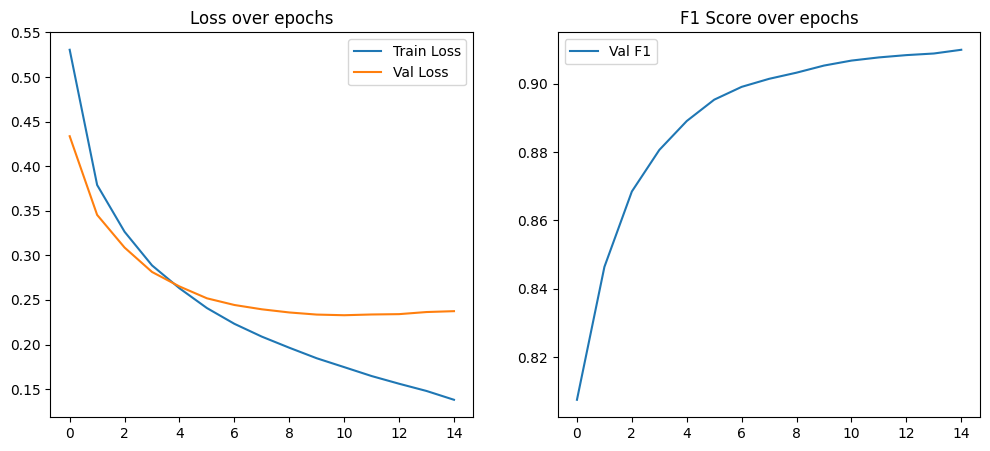

In [50]:
input_dim = X_tensor.shape[1]
output_dim = y_tensor.shape[1]

model = TfidfClassifier(input_dim, output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    n_epochs=15,
    scheduler=scheduler,
    early_stopping_patience=2,
    save_path='tfidf_best_model.pt',
    warmup_epochs=4
)

Модель с нагенерированными данными учится чуть хуже. Модель может создавать нетипичные примеры для выборки, потому что классы, на которых основывалась генерация изображений, были созданы мной вручную. Они могут расходиться с истинными классами. 